# Simple demonstration of spyIVP 

## What is it?
spyIVP is in principle YET ANOTHER(!!) general(ish)-purpose numerical IVP solver with some symbollic elements. It has a lot of overlap with Mathematica's NDSolve- NDSolve obviously is way more powerful for solving general equations (including PDEs).  But symODE is good for a range of useful problems, and has (or will have) a few features that aren't easily reproduced in Mathematics.  Overall it is less of a 'black-box' than NDSolve, for better or worse.

1. Can easily add explicit numerical code ( can in Mathematica too, but more hoops)
2. Can (shortly) integrate with tensorflow, bot for increased speed and to enable automatic differentiation.
3. The driving use case is ensembles of similar atoms interacting by long-range electric fields: large ensembles of states with long-range coupling

Other python ODE solving packages that may be more appropriate for general use:

* https://github.com/neurophysik/jitcode,
* http://bjodah.github.io/pyodesys/latest/index.html

They both seem more powerful, could likely replace this package for even the desired purpose. However I only learned about them after writing this, and I haven't tried them. To my mind it does seem unlikely that they'll be easily extended to large scales or to automatic differentiation of the whole system as is possible with Tensorflow, but please let me know if I"m mistaken


# Examples

Mostly spyIVP was written to enable assembling/solving master-equation based systems in python. That will be covered in [Solving master equations]. But of course it's also useful for more general stuff. A simple example that covers most bases is projectile motion: In particular, this handles an ensemble of interacting projectiles quite efficiently.




### Imports

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from pylab import *
from spylind import spyIVP as so
import sympy as sm;
sm.init_printing()

# Projectile motion

$$\frac{dx}{dt} = vx$$
$$\frac{dy}{dt} = vy$$

$$\frac{dv_x}{dt} = g$$
$$\frac{dv_y}{dt} = 0$$

In [2]:
xS, yS, vxS, vyS = sm.symbols("x, y, v_x, v_y", real=True)
g= -10.0
dy_dtD = {xS:vxS, 
       yS:vyS,
       vxS:0,
       vyS:g }

Munch({'tSym': t, 'dimSyms': [], 'prop_state_syms': [x, y, v_x, v_y], 'stationary_state_syms': [], 'driving_syms': [], 'state_dep_syms': []})
state dependent functions should have signature [t, x, y, v_x, v_y]
Not integrating first step (it's just the initial state)


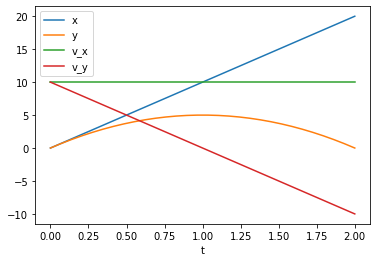

In [3]:
ode_s = so.ODESolver(dy_dtD,  dims={})
ode_s.set_initial_conditions({xS:0,yS:0,vxS:10,vyS:10}) 
ode_s.setup()
tSteps = linspace(0,2,30)
arr =ode_s.integrate(tSteps, 1.0)

#sm.ode
plot(tSteps, arr.real)
xlabel('t')
legend(dy_dtD.keys())

In [4]:
tEff = tSteps #+ (tSteps[1]-tSteps[0])/2
sym_res = dict(
    x= 10 *tEff,
    y = 10*tEff -5*tEff**2
    )
allclose(arr[:,0], sym_res['x'])
allclose(arr[:,1], sym_res['y'])

True

In [5]:
tS = sm.symbols("t")
xS = sm.Function('x')(tS)
vxS = sm.Function('v_x')(tS)
yS = sm.Function('y')(tS)
vyS = sm.Function('v_y')(tS)





In [6]:
from sympy.solvers import ode
sm.dsolve([sm.Eq(xS.diff(), vxS), sm.Eq(vxS.diff(), 0)])
eqL = [sm.Eq(yS.diff(),vyS), sm.Eq(vyS.diff(), g)]
sm.dsolve(sm.Eq(yS.diff(), g*tS) )

/home/morgan/miniforge3/envs/spylind/lib/python3.8/site-packages/IPython/lib/latextools.py:126: MatplotlibDeprecationWarning: 
The to_png function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
/home/morgan/miniforge3/envs/spylind/lib/python3.8/site-packages/IPython/lib/latextools.py:126: MatplotlibDeprecationWarning: 
The to_rgba function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
/home/morgan/miniforge3/envs/spylind/lib/python3.8/site-packages/IPython/lib/latextools.py:126: MatplotlibDeprecationWarning: 
The to_mask function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
/home/morgan/miniforge3/envs/spylind/lib/python3.8/si

Munch({'tSym': t, 'dimSyms': [z], 'prop_state_syms': [x, y, v_x, v_y], 'stationary_state_syms': [], 'driving_syms': [], 'state_dep_syms': [z]})
state dependent functions should have signature [t, z, x, y, v_x, v_y]
Not integrating first step (it's just the initial state)


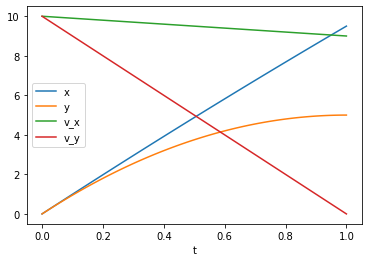

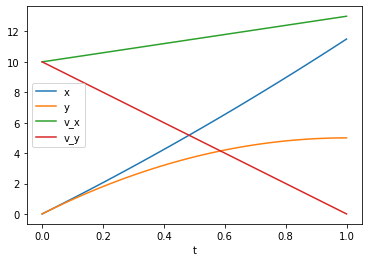

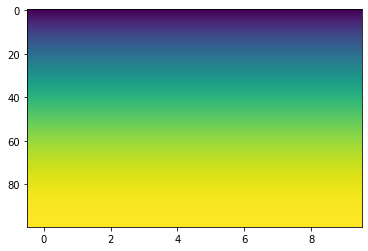

In [7]:
xS, yS, vxS, vyS = sm.symbols("x, y, v_x, v_y", real=True)
zS = sm.symbols("z", real=True)
g= -10.0
dy_dtD = {xS:vxS, 
       yS:vyS ,
       vxS:1 +zS,
       vyS: g  }

ode_s = so.ODESolver(dy_dtD,  dims={zS:linspace(-2,2,10)})
ode_s.set_initial_conditions({xS:0,yS:0,vxS:10,vyS:10}) 
ode_s.setup(bForceStateDimensions=True)
tSteps = linspace(0,1,100)
arr =ode_s.integrate(tSteps, 1.0)

plot(tSteps, arr[:,:,0].real)
xlabel('t')
legend(dy_dtD.keys())
figure()
plot(tSteps, arr[:,:,-1].real)
xlabel('t')
legend(dy_dtD.keys())
figure()
imshow(arr[:,1,:].real, aspect='auto')

## An ensemble of interacting projectiles (via a mutual attraction)

What happens if the projectiles experience a force pushing toward their center-of-mass.

Currently there's no easy way to decsribe the interaction symbollically (though may yet be added). It's easy to do numerically however.

The interaction is $F_j = \sum_{i\neq j}^n k \frac{y_i-y_j}{|(y_i-y_j)^3|}$. This is infinite as particles get close, which is obviously a problem for a simulation. So we'll need to damp it at close range.



Munch({'tSym': t, 'dimSyms': [ind], 'prop_state_syms': [x, y, v_x, v_y], 'stationary_state_syms': [], 'driving_syms': [], 'state_dep_syms': [k]})
state dependent functions should have signature [t, ind, x, y, v_x, v_y]
Not integrating first step (it's just the initial state)


Text(0.5, 1.0, 'mutually attractive projectiles')

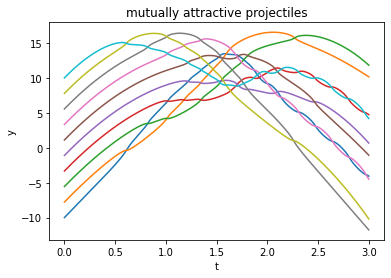

In [8]:
xS, yS, vxS, vyS, kS = sm.symbols("x, y, v_x, v_y, k", real=True)
indS = sm.symbols("ind", real=True)
g= -10.0
dy_dtD = {xS:vxS, 
       yS:vyS,
       vxS:1,
       vyS: g + 30*kS }

ode_s = so.ODESolver(dy_dtD,  dims={indS:arange(10)})
ode_s.set_initial_conditions({xS:0*ones(10),yS:linspace(-10,10,10),vxS:10*ones(10),vyS:15*ones(10) }) 
def couplingF(t, dimAxes, state, driving_vals):
    x,y,vx,vy = state
    diff = y[:,newaxis] - y[newaxis,:]
    diff[np.diag_indices_from(diff)]=1e20 # Stop divide by zeros due to distance of particles from themselves
    sq_diff = diff**2 / (1- exp(-(diff/0.3)**2 ))#  Need to damp the interaction for close particles to avoid singularities
    #sq_diff[np.diag_indices_from(sq_diff)]=1. 
    F = -np.sum(sign(diff)/sq_diff, axis=1)
    return F
ode_s.set_state_dep_funcs({kS:couplingF})

ode_s.setup(bForceStateDimensions=True)
tSteps = linspace(0,3.,2000)
arr =ode_s.integrate(tSteps, 1.0)

plot(tSteps, arr[:,1,:].real)
xlabel('t')
ylabel('y')
title("mutually attractive projectiles")



## Using a custom output function

Munch({'tSym': t, 'dimSyms': [ind], 'prop_state_syms': [x, y, v_x, v_y], 'stationary_state_syms': [], 'driving_syms': [], 'state_dep_syms': [k]})
state dependent functions should have signature [t, ind, x, y, v_x, v_y]
Not integrating first step (it's just the initial state)


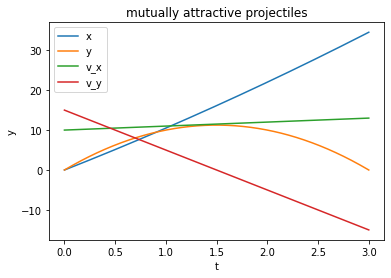

In [9]:
xS, yS, vxS, vyS, kS = sm.symbols("x, y, v_x, v_y, k", real=True)
indS = sm.symbols("ind", real=True)
g= -10.0
dy_dtD = {xS:vxS, 
       yS:vyS,
       vxS:1,
       vyS: g + 30*kS }

ode_s = so.ODESolver(dy_dtD,  dims={indS:arange(10)})
ode_s.set_initial_conditions({xS:0*ones(10),yS:linspace(-10,10,10),vxS:10*ones(10),vyS:15*ones(10) }) 
def couplingF(t, dimAxes, state, driving_vals):
    x,y,vx,vy = state
    diff = y[:,newaxis] - y[newaxis,:]
    diff[np.diag_indices_from(diff)]=1e20 # Stop divide by zeros due to distance of particles from themselves
    sq_diff = diff**2 / (1- exp(-(diff/0.3)**2 ))#  Need to damp the interaction for close particles to avoid singularities
    #sq_diff[np.diag_indices_from(sq_diff)]=1. 
    F = -np.sum(sign(diff)/sq_diff, axis=1)
    return F
ode_s.set_state_dep_funcs({kS:couplingF})

def output_mean_state(state):
    mean_state = state.mean(axis=1)
    return mean_state
ode_s.set_online_processing(output_mean_state)


ode_s.setup(bForceStateDimensions=True)
tSteps = linspace(0,3.,2000)
arr =ode_s.integrate(tSteps, 1.0)

plot(tSteps, arr[:,:].real)
xlabel('t')
ylabel('y')
title("mutually attractive projectiles")
legend(ode_s.symsD.prop_state_syms)

